1. Fetch and preprocess documents that will be used for retrieval.
2. Index those documents for semantic search and create a retriever tool for the agent.
3. Build an agentic RAG system that can decide when to use the retriever tool.

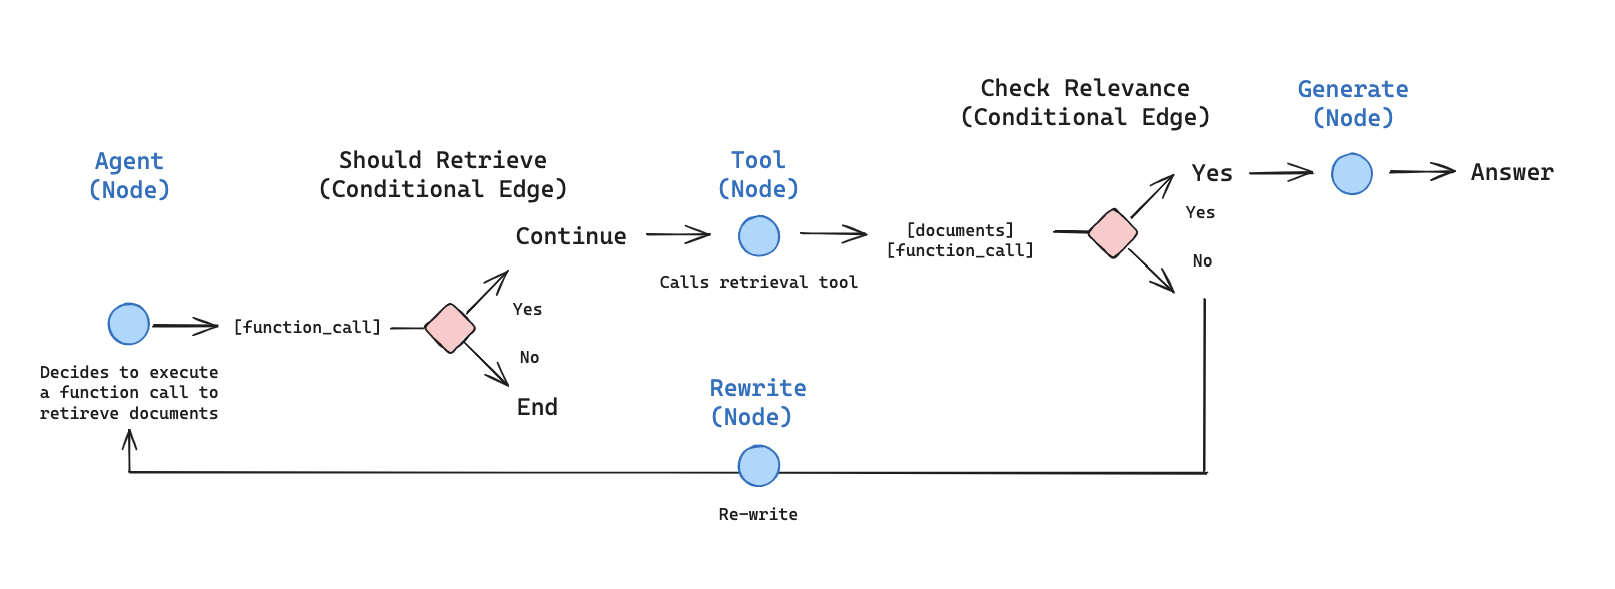

In [2]:
!pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 12.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from dotenv import load_dotenv
import os

load_dotenv("/content/drive/MyDrive/LangGraph/.env")

True

## 1. Preprocess documents

1. RAG 시스템에서 사용할 문서를 가져오도록 함. WebBaseLoader를 사용하여 페이지의 내용을 가져오겠음.

In [14]:
# 웹 페이지 URL에서 콘텐츠를 가져와 Langchain에서 사용할 수 있는 Document 객체로 바꿔주는 도구
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://sendbird.com/ko/blog/what-is-agentic-ai",
    "https://blog.langchain.com/benchmarking-multi-agent-architectures/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [20]:
docs[0][0].metadata

{'source': 'https://sendbird.com/ko/blog/what-is-agentic-ai',
 'title': '에이전틱 AI(Agentic AI)란? 입문자용 가이드 | 센드버드',
 'description': '에이전틱 AI는 설정된 목표를 달성하기 위해 자율적으로 의사결정을 내리고, 작업을 계획하며, 유저와의 상호작용에서 학습하는 인공지능 시스템입니다.',
 'language': 'ko-KR'}

In [21]:
docs[0][0].page_content.strip()[:1000]

'에이전틱 AI(Agentic AI)란? 입문자용 가이드 | 센드버드\n\n\n\n\n\n\n\n\n  왜 센드버드인가? 솔루션  리소스  요금 정책    로그인솔루션 문의 \n\t\t\t왜 센드버드인가?\n\t\t\n\t\t\t\t솔루션\n\t\t\t  \n\t\t\t리소스\n\t\t  \n\t\t\t요금 정책\n\t\t   솔루션 문의 로그인 \n        블로그\n        \n        AI Agent\n        에이전틱 AI(Agentic AI)란? 입문자용 가이드  \n        On This Page\n       에이전틱 AI는 어떻게 다를까요? 에이전틱 AI은 어떻게 작동되나요? 에이전틱 AI의 장점 에이전틱 AI 활용 분야 에이전틱 AI 시스템의 도전과제 및 리스크 에이전틱 AI 배포 모범사례 기업을 위한 차세대 자동화 솔루션    언제 어디서나 응답하는 AI 고객 서비스  AI 에이전트 생성하기On This Page 에이전틱 AI(Agentic AI)란? 입문자용 가이드   Feb 7, 2025   \n      Sanghee Lee\n     \n      General Manager, Global, AI Business Strategy\n    \n        On This Page\n       에이전틱 AI는 어떻게 다를까요? 에이전틱 AI은 어떻게 작동되나요? 에이전틱 AI의 장점 에이전틱 AI 활용 분야 에이전틱 AI 시스템의 도전과제 및 리스크 에이전틱 AI 배포 모범사례 기업을 위한 차세대 자동화 솔루션    언제 어디서나 응답하는 AI 고객 서비스  AI 에이전트 생성하기On This PageAI agent platformAI agent builderAI customer serviceAI agent integrations    언제 어디서나 응답하는 AI 고객 서비스  AI 에이전트 생성하기  에이전틱 AI(Agentic AI)는 AI 기술이 이룬 또 하나의 중요한 혁신입니다. \n챗GPT와 같은 파운데

2. 가져온 문서를 더 작은 청크로 나누어 벡터 저장소에 인덱싱함.
- 먼저 문단(\n\n) 기준으로 자를 수 있나 시도
- 안 되면 문장(.) 기준으로 시도
- 그것도 안 되면 단어() 기준
- 글자 단위 -> 정말 안 되면 chunk_size 기준으로 강제 자름

In [22]:
# 긴 텍스트 문서를 일정한 크기로 나누기 위한 LangChain 유틸리티.
# 특히 LLM 입력 길이 제한(Token limit)에 맞춰 텍스트를 자를 때 자주 사용됨.
# chunk_size: 텍스트를 나눌 때 각 조각의 크기 / chunk_overlap: 겹치는 정도
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100,
    chunk_overlap=50,
)

doc_splits = text_splitter.split_documents(docs_list)

In [25]:
doc_splits[:3]

[Document(metadata={'source': 'https://sendbird.com/ko/blog/what-is-agentic-ai', 'title': '에이전틱 AI(Agentic AI)란? 입문자용 가이드 | 센드버드', 'description': '에이전틱 AI는 설정된 목표를 달성하기 위해 자율적으로 의사결정을 내리고, 작업을 계획하며, 유저와의 상호작용에서 학습하는 인공지능 시스템입니다.', 'language': 'ko-KR'}, page_content='에이전틱 AI(Agentic AI)란? 입문자용 가이드 | 센드버드'),
 Document(metadata={'source': 'https://sendbird.com/ko/blog/what-is-agentic-ai', 'title': '에이전틱 AI(Agentic AI)란? 입문자용 가이드 | 센드버드', 'description': '에이전틱 AI는 설정된 목표를 달성하기 위해 자율적으로 의사결정을 내리고, 작업을 계획하며, 유저와의 상호작용에서 학습하는 인공지능 시스템입니다.', 'language': 'ko-KR'}, page_content='왜 센드버드인가? 솔루션  리소스  요금 정책    로그인솔루션 문의'),
 Document(metadata={'source': 'https://sendbird.com/ko/blog/what-is-agentic-ai', 'title': '에이전틱 AI(Agentic AI)란? 입문자용 가이드 | 센드버드', 'description': '에이전틱 AI는 설정된 목표를 달성하기 위해 자율적으로 의사결정을 내리고, 작업을 계획하며, 유저와의 상호작용에서 학습하는 인공지능 시스템입니다.', 'language': 'ko-KR'}, page_content='왜 센드버드인가?\n\t\t\n\t\t\t\t솔루션\n\t\t\t  \n\t\t\t리소스\n\t\t  \n\t\t\t요금 정책')]

In [23]:
doc_splits[0].page_content.strip()

'에이전틱 AI(Agentic AI)란? 입문자용 가이드 | 센드버드'

## 2. Create a retriever tool

이제 문서를 분할했으므로 이를 의미 검색에 사용할 벡터 저장소에 색인할 수 있음.

1. 메모리 내 벡터 저장소와 OpenAI 임베딩을 사용.
- 과정: 텍스트 문서 -> 임베딩 벡터 -> 메모리 기반 저장소 -> 검색기 객체 생성

In [26]:
# OpenAI에서 제공하는 모델을 사용해 문자열 텍스트를 고차원 벡터(숫자 배열)로 변환. -> 벡터로 변환하는 도구 (text-embedding-3-small)
from langchain_openai import OpenAIEmbeddings
# 임베딩된 벡터들을 메모리(RAM)에 저장하고, 쿼리 벡터와 가장 유사한 벡터들을 검색해주는 간단 벡터 데이터베이스.
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings()
)

retriever = vectorstore.as_retriever()

In [27]:
retriever

VectorStoreRetriever(tags=['InMemoryVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x7f1c6a8f6720>, search_kwargs={})

2. Langchain의 사전 구축된 기능을 사용하여 검색 도구를 만듦.

In [30]:
# LangChain에서 사용하는 도구 tool 생성 함수 중 하나로, 벡터 검색 기반 retriever 객체를 Tool로 wrapping해 Agent가 사용할 수 있도록 만들어줌.
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about agent.",
)

In [31]:
retriever_tool.description

'Search and return information about agent.'

In [32]:
retriever_tool.args_schema.schema()

/tmp/ipython-input-1370611407.py:1: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  retriever_tool.args_schema.schema()


{'description': 'Input to the retriever.',
 'properties': {'query': {'description': 'query to look up in retriever',
   'title': 'Query',
   'type': 'string'}},
 'required': ['query'],
 'title': 'RetrieverInput',
 'type': 'object'}

In [33]:
retriever_tool.__dict__

{'name': 'retrieve_blog_posts',
 'description': 'Search and return information about agent.',
 'args_schema': langchain_core.tools.retriever.RetrieverInput,
 'return_direct': False,
 'verbose': False,
 'callbacks': None,
 'callback_manager': None,
 'tags': None,
 'metadata': None,
 'handle_tool_error': False,
 'handle_validation_error': False,
 'response_format': 'content',
 'func': functools.partial(<function _get_relevant_documents at 0x7f1d547b11c0>, retriever=VectorStoreRetriever(tags=['InMemoryVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x7f1c6a8f6720>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'),
 'coroutine': functools.partial(<function _aget_relevant_documents at 0x7f1c69e37f60>, retriever=VectorStoreRetriever(tags=['InMemoryVectorStore', 'OpenAIEmbe

3. 도구 테스트:

In [35]:
x = retriever_tool.invoke({"query": "에이전틱 AI가 이전 모델들과 차별화되는 주요 기능"})
print(x)

아래는 에이전틱 AI이 이전 모델들과 차별화되는 주요 기능입니다.
체이닝(Chaining)

에이전틱 AI는 가용한 도구와 지식 소스를 자율적으로 활용하여 목표를 실현합니다.

에이전틱 AI 가이드에서 다룰 내용:

에이전틱 AI는 추론, 도구 활용, 실시간 디지털 시스템 연동과 같은 기능을 통해,


## 3. Generate query

에이전틱 RAG 그래프를 위한 컴포넌트(노드, 엣지) 구축. 각 컴포넌트들은 MessageState라는 그래프 상태를 기반으로 작동하며, 이는 message라는 키를 포함함. (이 키는 채팅 메시지들의 리스트를 담고 있음.)

1. generate_query_or_respond 노드 구축. 이 노드는 현재 그래프 상태(메시지 리스트)를 바탕으로 LLM을 호출하여 응답을 생성함. 입력된 메시지를 보고, retriever 도구를 사용할지 혹은 사용자에게 직접 응답할지를 판단함. 이때, 이전에 생성한 retriever_tool을 .bind_tools를 통해 채팅 모델에 연결해 줌.
- bind_tools: LangChain에서 에이전트에게 tool을 고정(binds)시켜서 사용할 수 있게 해 주는 메서드.

In [36]:
from langgraph.graph import MessagesState
# LangChain 또는 유사한 LLM 기반 프레임워크에서 chat-based LLM을 초기화하기 위한 함수.
from langchain.chat_models import init_chat_model

response_model = init_chat_model("openai:gpt-4.1", temperature=0)

def generate_query_or_respond(state: MessagesState):
  response = (
      response_model
      .bind_tools([retriever_tool]).invoke(state["messages"])
  )
  return {"messages": [response]}

2. 무작위 입력에 대해 시도.

In [37]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


In [40]:
generate_query_or_respond(input)["messages"][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_L7ADfqSQbPEfa7S9yo3icC2K', 'function': {'arguments': '{"query":"multi agent system"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 66, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_3502f4eb73', 'id': 'chatcmpl-CL2VUgpT1BOPCTGUun9C0v1mRtbTP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5a8823e4-b61d-42fc-9211-503a12faedd7-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'multi agent system'}, 'id': 'call_L7ADfqSQbPEfa7S9yo3icC2K', 'type': 'tool_call'}], usage_metadata={'input_tokens': 66, 'output_tokens': 17, 'total_toke

3. 의미 검색이 필요한 질문을 시도.

In [39]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Cognition team say about multi agenets system?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_wf9Mrhhzi9ha3XG8e7u1H51z)
 Call ID: call_wf9Mrhhzi9ha3XG8e7u1H51z
  Args:
    query: multi agent system


## 4. Grade documents

1. 검색된 문서들이 질문과 관련이 있는지를 판단하는 역할을 하는 **조건부 엣지**(grade_documents) 추가.

이를 위해 문서 평가를 위한 구조화된 출력 스키마인 GradeDocuments를 사용하는 모델을 사용함.

grade_documents 함수는 문서의 평가 결과에 따라 다음에 이동할 노드의 이름을 반환함. 즉, 관련성이 높으면 generate_answer 노드로, 관련성이 낮으면 rewrite_question 노드로 이동하게 됨.

In [41]:
# 데이터 유효성 검사, 직렬화, 자동 문서화 등을 도와주는 python 라이브러리
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

# BaseModel: 데이터 구조를 정의하는 클래스
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("openai:gpt-4.1", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

2. 도구 응답에서 관련 없는 문서로 convert_to_messages 실행.

In [42]:
# LangChain에서 일반적인 대화 이력(list of dicts, strings 등)을 내부 메시지 객체로 변환하는 함수.
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Cognition team say about multi agents system?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "multi agent system"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

3. 관련 문서

In [46]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Cognition team say about multi agents system?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "multi agent system"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "The Cognition team, in their blog post titled \"Don't Build Multi-Agents\", express caution (or even skepticism) about using multi-agent systems - especially in complex production settings. But their stance isn't anti-agentic as the title suggests.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

## 5. Rewrite question

1. rewrite_question 노드를 구축함. 검색 도구는 잠재적으로 관련성이 없는 문서를 반환할 수 있으며, 이는 원래 사용자 질문을 개선해야 할 필요성을 나타냄. 이를 위해 rewrite_question 노드를 다음과 같이 명명.

In [47]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

2. 시도

In [48]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Cognition team say about multi agents system?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

Certainly! Here’s an improved version of the question:

**"What is the Cognition team's perspective on multi-agent systems?"**

Or, for more specificity:

**"How does the Cognition team describe or evaluate multi-agent systems?"**


## 6. Generate an answer

1. generate_answer 노드 빌드: 채점자 검사를 통과하면 원래 질문과 검색된 컨텍스트를 기반으로 최종 답변을 생성할 수 있음.

In [49]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

2. 시도

In [50]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Cognition team say about multi agents system?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "The Cognition team, in their blog post titled \"Don't Build Multi-Agents\", express caution (or even skepticism) about using multi-agent systems - especially in complex production settings. But their stance isn't anti-agentic as the title suggests.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

The Cognition team expresses caution or skepticism about using multi-agent systems, particularly in complex production environments. However, their stance is not entirely against agentic approaches, despite the provocative title "Don't Build Multi-Agents." They advise careful consideration rather than outright rejection of multi-agent systems.


## 7. Assemble the graph

1. generate_query_or_respond 실행
    - 여기서 도구 호출(tool_calls)이 필요한지 판단함.

2. 도구 호출 여부 확인 (tools_condition)
    - tool_calls가 있으면 → retriever_tool을 불러서 관련 문서를 검색
    - 없으면 → 바로 사용자에게 답변

3. 검색 결과 평가 (grade_documents)
    - 검색된 문서가 질문과 관련 없으면 → rewrite_question으로 질문을 다시 쓰고, 다시 generate_query_or_respond 실행
    - 관련 있으면 → generate_answer 단계로 넘어가서, 검색된 문서 내용을 포함해 최종 답변 생성

In [51]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# 순환하며 실행할 노드들을 정의
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# 검색을 수행할지 여부 결정
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # LLM의 판단 (retriever_tool 호출 여부 혹은 사용자에게 직접 응답)
    tools_condition,
    {
        # 조건 결과를 그래프의 노드로 매핑
        "tools": "retrieve",
        END: END,
    },
)

# `retrieve` 노드 실행 이후의 경로 설정
workflow.add_conditional_edges(
    "retrieve",
    # 검색된 문서의 관련성을 평가
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# 그래프 컴파일
graph = workflow.compile()

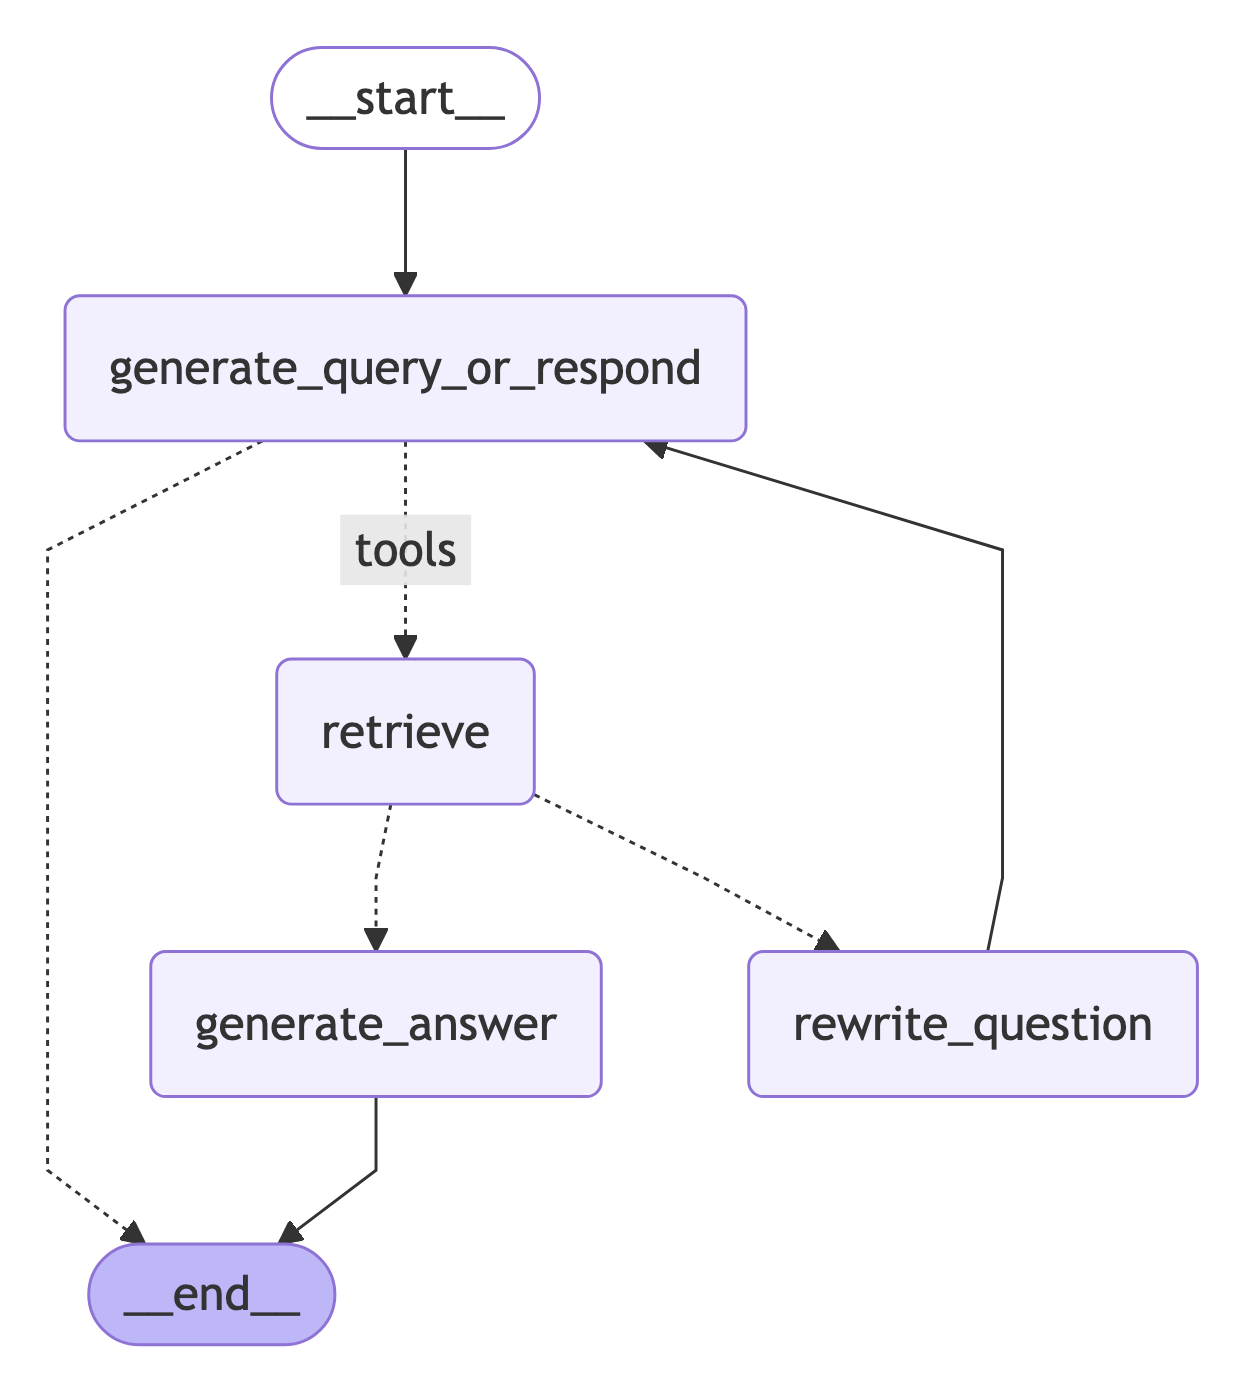

## 8. Run the agentic RAG

In [58]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Cognition team say about multi agents system?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_onsia0VlZlOWoUhrg8ppVGB1)
 Call ID: call_onsia0VlZlOWoUhrg8ppVGB1
  Args:
    query: multi agent system



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

motivation for multi-agent systems.Another motivator for multi-agent systems is to follow engineering best practices. Many teams we talk to prefer to design separate agents as they are more modular, which makes them easier to update, evaluate, maintain, and parallelize.A final motivator for multi-agent systems is that many agents will be developed by different developers and teams. In this case, a naive single agent architecture may not be feasible. If each agent is able to contribute something unique, an

an effective multi-agent system can achieve more than a given agent in isolation.Fo